In [3]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import *

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [16]:
data_dir = '/opt/ml/image-classification-level1-34/Input/data/eval'
img_dir = f'{data_dir}/newimages'

In [17]:
class TestDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_list = glob(img_dir+"/*")  
        self.transform = transforms.Compose([
            Resize((224,224)),
            ToTensor(),
        ])

    def __getitem__(self, index):
        image = Image.open(self.img_list[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_list)

In [18]:
dataset = TestDataset(img_dir=img_dir)
loader = DataLoader(dataset, batch_size=12, shuffle=True)

In [40]:
def rand_bbox(size, lam): # size : [Batch_size, Channel, Width, Height]
    """

    cut_mix function

    """
    W = size[2] 
    H = size[3] 
    cut_rat = np.sqrt(1. - lam)/1.5  # 패치 크기 비율
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)  

   	# 패치의 중앙 좌표 값 cx, cy
    cx = np.random.randint(W*0.7, W)
    cy = np.random.randint(H*0.3, H*0.7) 
    

    # 패치 모서리 좌표 값 
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
   
    return bbx1, bby1, bbx2, bby2

In [37]:
beta = 0.2
cutmix_prob = 1

In [38]:
%matplotlib inline

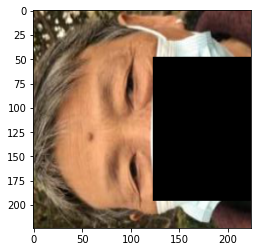

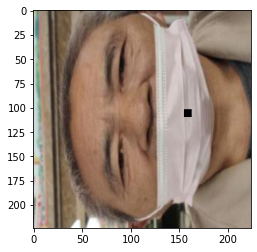

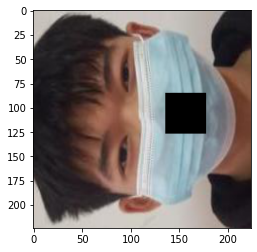

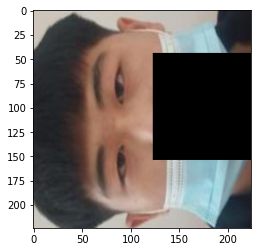

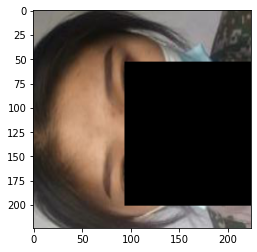

In [41]:
count = 0
for inputs in loader:
    count += 1
    inputs = inputs.to(device)
    r = np.random.rand(1)
    if beta > 0 and  r < cutmix_prob:     
        lam = np.random.beta(beta, beta)
        rand_index = torch.randperm(inputs.size()[0]).to(device)      
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = 0
        plt.imshow(np.transpose(inputs.cpu().numpy()[0]))
        plt.show()
    if count == 5: break